In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
seed=2023

In [2]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = seed # Reproducibility purposes
rand = algorithm_globals.random.uniform
# Note that once we fix this seed, every time we call rand, the points will be random but we will now the order

In [3]:
from IPython.core.interactiveshell import InteractiveShell

# This option will print all entries in a Jupyter notebook cell
InteractiveShell.ast_node_interactivity = "all"

# Return to normal
# InteractiveShell.ast_node_interactivity = "last_expr"

In [4]:
# Auxiliary functions to save and load the classifiers into pickle objects:
import pickle
def add_to_pickle(path, item):
    with open(path, 'wb') as file:
        pickle.dump(item, file, pickle.HIGHEST_PROTOCOL)
        
def load_from_pickle(path):
    objects = []
    with (open(path, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break
    if type(objects)==list and len(objects)==1:
        return objects[0]
    else:
        return objects

# Preprocessing:

## Read the data

In [5]:
# Read the data file into a pandas DataFrame
df = pd.read_csv('iris.data', header=None, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])

# Extract labels
y = df['class']

# Move labels to first column
# (in case we want to add new variables, such as petal area, etc.)
df.drop(columns=['class'], inplace=True)
df.insert(0, 'class', y)

# Extract the values of the features
X = df.iloc[:,1:]

# Retrieve the different labels and features
classes = df['class'].unique().tolist()
features = df.columns[1:].tolist()

In [6]:
# Note that there are 50 elements of each class:
df['class'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: class, dtype: int64

In [7]:
# Note that there aren't any missing values:
print(df.isnull().sum())

class           0
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
dtype: int64


## Visualize the data:

<AxesSubplot:>

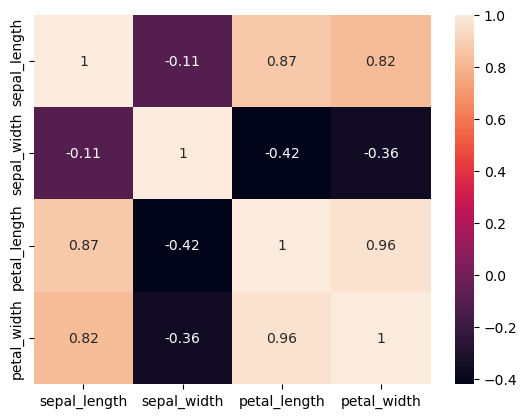

In [8]:
# Create a correlation matrix
corr_matrix = X.corr()
# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True)

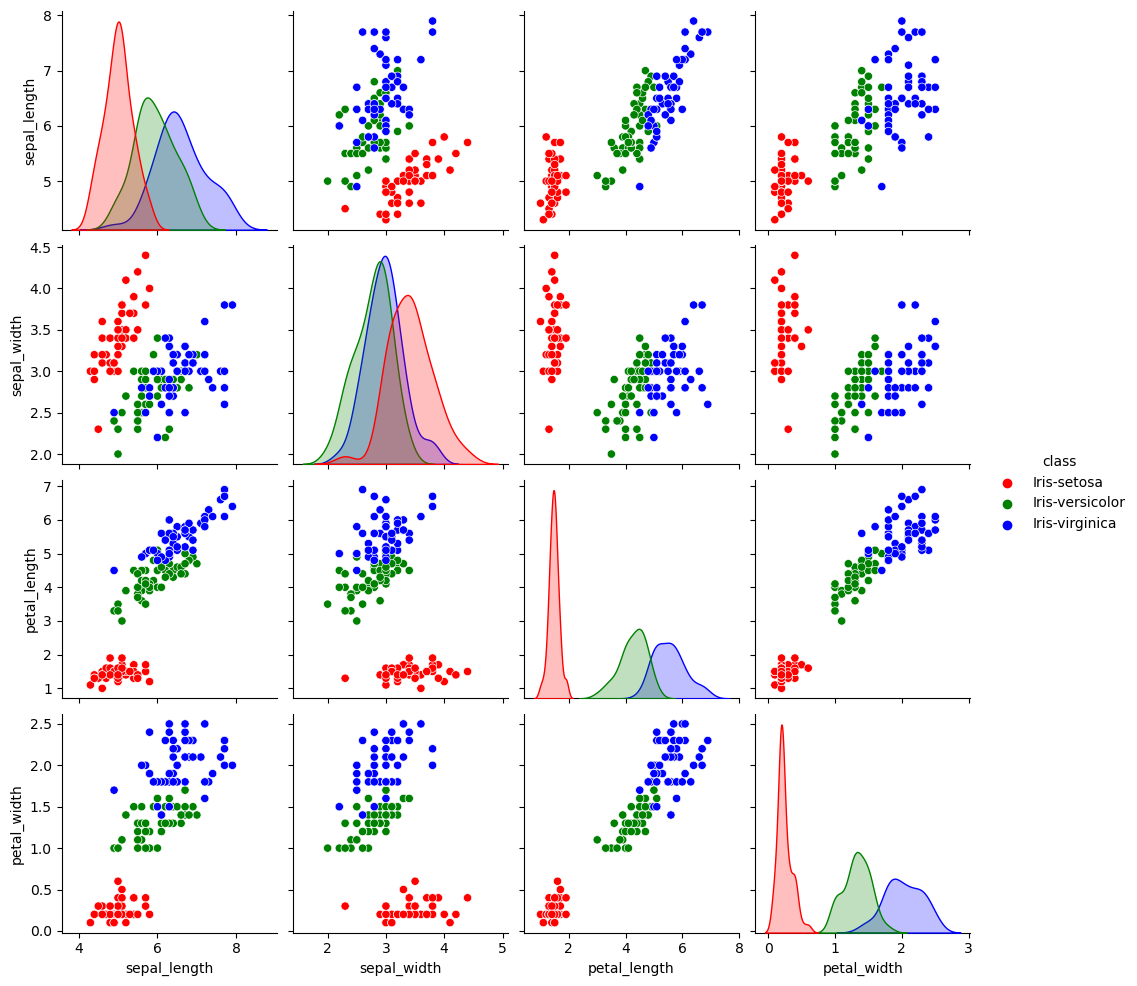

In [9]:
# Plot the scatter matrix with the seaborn package
palette = {'Iris-setosa': 'red', 'Iris-versicolor': 'green', 'Iris-virginica': 'blue'}
sns.pairplot(df, hue='class', palette=palette)
plt.show()

<AxesSubplot:xlabel='class', ylabel='sepal_length'>

<AxesSubplot:xlabel='class', ylabel='sepal_width'>

<AxesSubplot:xlabel='class', ylabel='petal_length'>

<AxesSubplot:xlabel='class', ylabel='petal_width'>

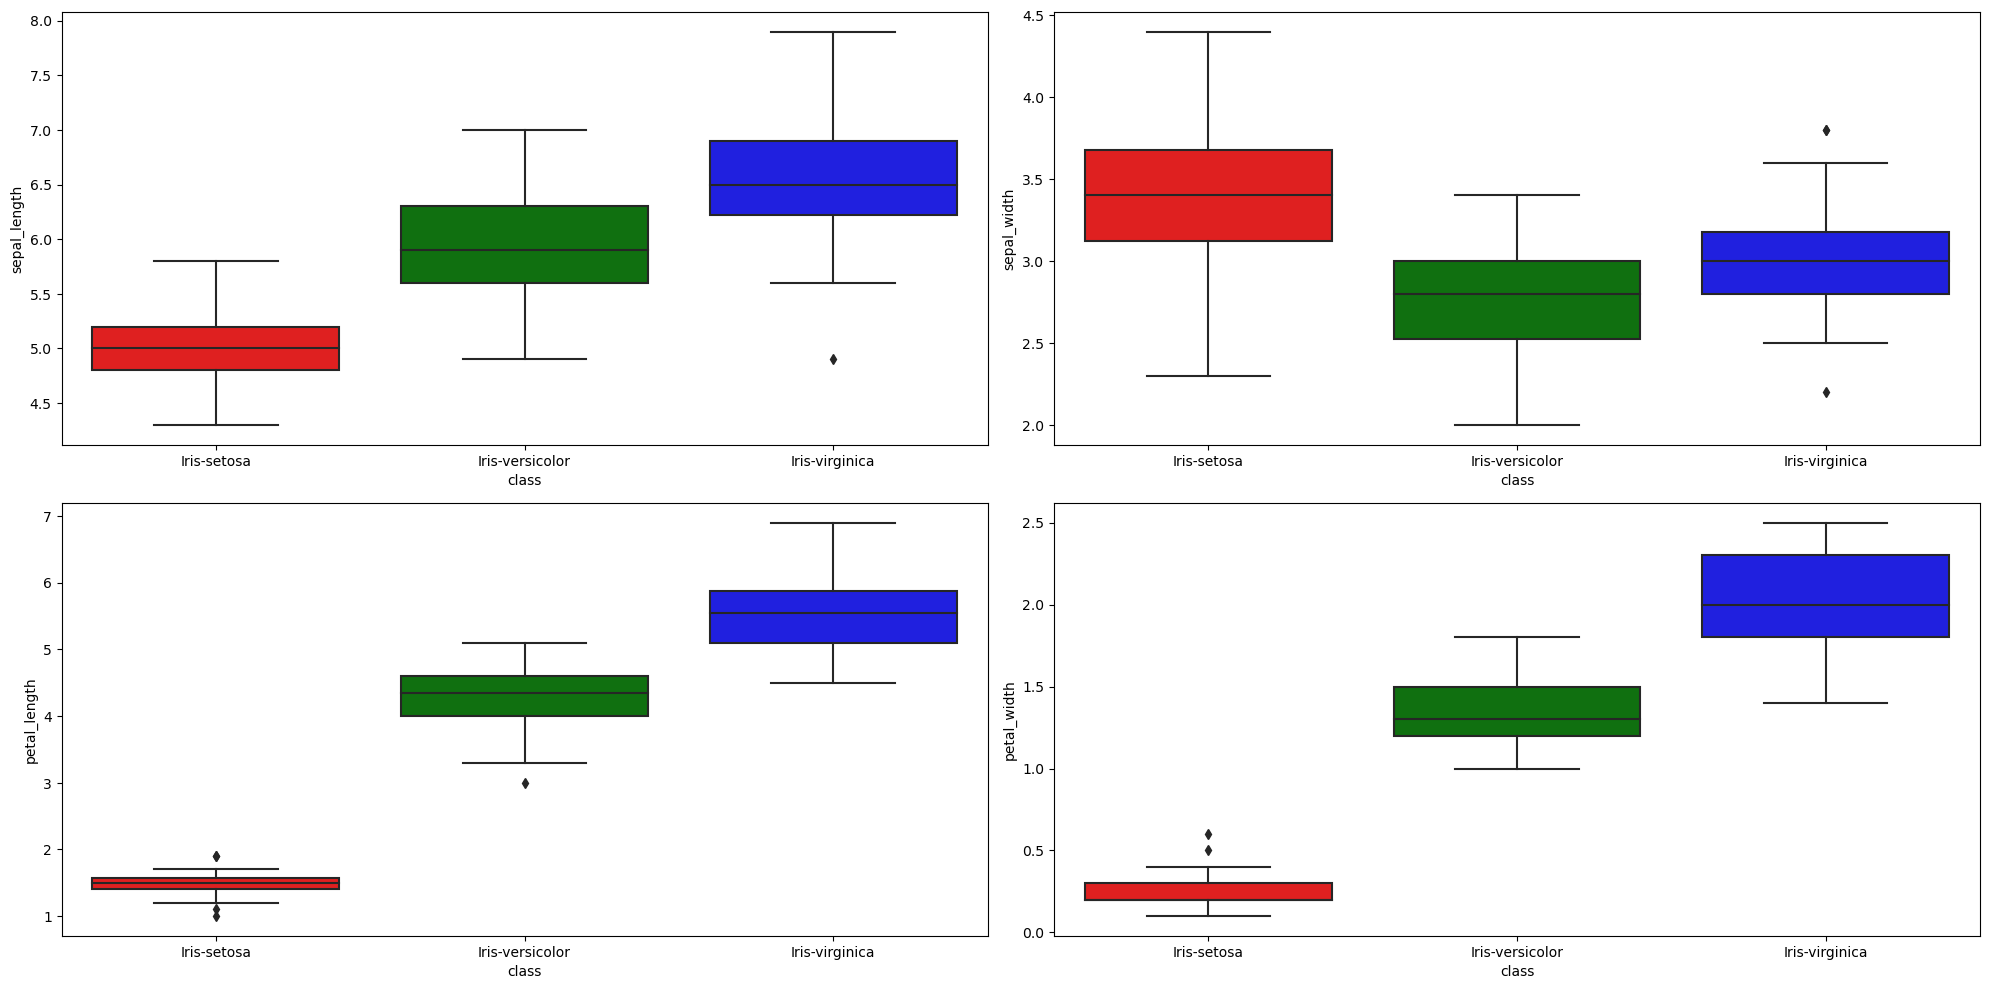

In [10]:
# Boxplots

fig, axs = plt.subplots(nrows=2, ncols=len(features)//2, figsize=(20, 10))
for i, feature in enumerate(features):
    row = i // (len(features)//2)
    col = i % (len(features)//2)
    sns.boxplot(data=df, x='class', y=str(feature), palette=palette, ax=axs[row, col])
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='sepal_length', ylabel='Count'>

<AxesSubplot:xlabel='sepal_width', ylabel='Count'>

<AxesSubplot:xlabel='petal_length', ylabel='Count'>

<AxesSubplot:xlabel='petal_width', ylabel='Count'>

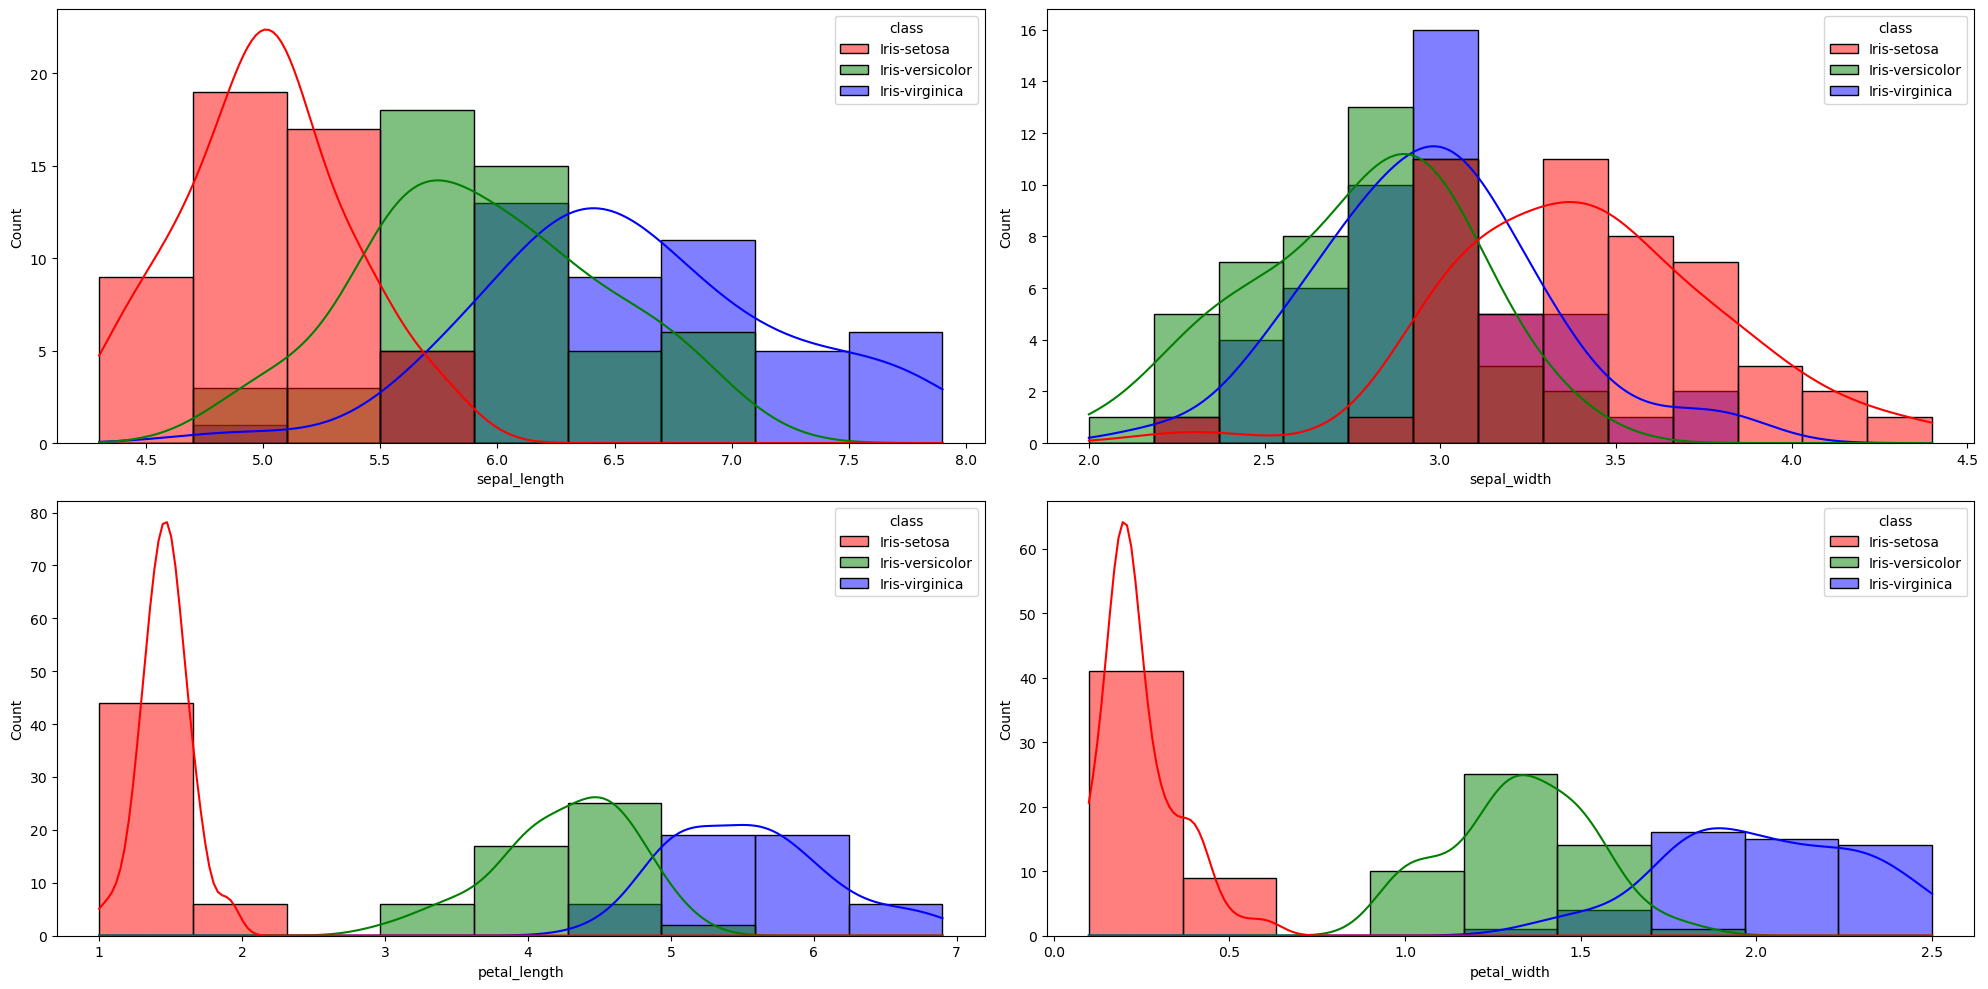

In [11]:
# Histplots
fig, axs = plt.subplots(nrows=2, ncols=len(features)//2, figsize=(20, 10))
for i, feature in enumerate(features):
    row = i // (len(features)//2)
    col = i % (len(features)//2)
    sns.histplot(data=df, x=str(feature), hue='class', palette=palette, kde=True, alpha=0.5, ax=axs[row, col])
plt.tight_layout()
plt.show()

## Reescaling the data:

Since we will be encoding the features into quantum rotation gates (angle encoding), we will reescale the data to be in between $[0, 2 \pi)$

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler((-np.pi,np.pi)).fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

## Split the data:

We will divide the dataset of length 150 in a balanced train set of 117 elements (78%) and a test set of 42 elements.
The train set will be subdivided in 3 sub-train sets each one of 39 elements consisting of 13 elements of each class.

The test set will be 'tested' for the 3 support vector machines at the same time, while each kernel's classifier will be trained on a different balanced dataset.

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

In [15]:
# Divide the dataframe in a train set and test set.
split = StratifiedShuffleSplit(n_splits=1, test_size=42, random_state=seed)
for train_index, test_index in split.split(X_scaled, y):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [16]:
# Check that data is balanced
y_train.value_counts()
y_test.value_counts()

Iris-versicolor    36
Iris-setosa        36
Iris-virginica     36
Name: class, dtype: int64

Iris-virginica     14
Iris-setosa        14
Iris-versicolor    14
Name: class, dtype: int64

In [17]:
#Insert the labels for creating evenly the sub-train sets
X_train.insert(0, 'class', y_train)

# Group the data by class
grouped = X_train.groupby('class')

In [18]:
# Split each group in 3 subgroups after having shuffled.
subgroups = [np.array_split(grouped.get_group(label).sample(frac=1, random_state=seed), 3) for label in classes]

In [19]:
# Join the 3 subgroups into each sub train set, and shuffle to mix the classess
X_subtrain_sets = []
y_subtrain_sets = []
for k in range(3):
    # Concatenate each class subgroup created
    concat_subgroup = pd.concat(item[k] for item in subgroups)
    
    # Shuffle to mix the different classes
    shuffled_subgroup = concat_subgroup.sample(frac=1, random_state=seed)
    
    # Extract labels
    y_subtrain_sets.append(shuffled_subgroup['class'].apply(lambda x: 1 if x==classes[k] else 0))
    
    # Extract values
    X_subtrain_sets.append(shuffled_subgroup.iloc[:,1:])
X_train_1, X_train_2, X_train_3 = X_subtrain_sets
y_train_1, y_train_2, y_train_3 = y_subtrain_sets

In [20]:
# Consistency check to see that every train group has 12 elements of each class!
[y_train_set.value_counts() for y_train_set in y_subtrain_sets]

[0    24
 1    12
 Name: class, dtype: int64,
 0    24
 1    12
 Name: class, dtype: int64,
 0    24
 1    12
 Name: class, dtype: int64]

# Classification with the Quantum Kernels:

## Create parametrized classifier circuit:

Since we have 4 features, and we will encode our features in a parametrized QisKit circuit, we won't be needing more than 2 qubits.

In [21]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from sklearn.svm import SVC
from tqdm import tqdm

In [22]:
n = 2 # qubits
N = 4 # features

We will use an ansatz with 6 parameters:
- 4 first parameters: Feature encoding (angle encoding)
- 2 last parameters: Kernel training

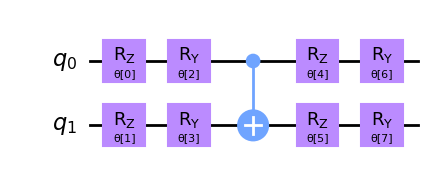

In [23]:
TwoLocal(
    num_qubits=n,
    rotation_blocks=['rz','ry'],
    entanglement_blocks='cx',
    reps=1,
    entanglement='pairwise' # Doesn't really matter since we are with 2 qubits.
    ).decompose().draw('mpl',fold=-1)

We will try to use only 2 trainable parameters! So we define the same circuit without the final gates!

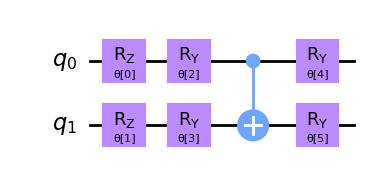

In [24]:
# We skip the final rotation layers
TL = TwoLocal(
    num_qubits=n,
    rotation_blocks=['rz','ry'],
    entanglement_blocks='cx',
    reps=1,
    entanglement='pairwise',
    skip_final_rotation_layer=True
).decompose()

# Add only 2 rotation gates!
P = ParameterVector('θ',N+2)
for i in range(2):
    TL.ry(P[i+4],i)
TL.draw('mpl',fold=-1)

The idea will be to fix the last two parameters randomly, as they are trainable ones, and optimize them based on a loss function.
We can do this manually, but QisKit has now a class that allows to implement this much more quickly.

In [25]:
# Fix randomly the last 2 parameters for each dataset
initial_training_parameters_list = [{item:rand(-np.pi,np.pi,1)[0] for item in TL.parameters[4:6]} for i in range(3)]
initial_training_parameters_list

[{ParameterVectorElement(θ[4]): -2.5883301971925565,
  ParameterVectorElement(θ[5]): -1.7565270058958784},
 {ParameterVectorElement(θ[4]): -2.4305210900314895,
  ParameterVectorElement(θ[5]): -0.3583499457220696},
 {ParameterVectorElement(θ[4]): 1.2398698888567505,
  ParameterVectorElement(θ[5]): 0.29017097583738405}]

## Trainable Fidelity Quantum Kernel

In this first approach we will use the default fidelity computation, using the Statevector simulation through the Sampler primitive.

In [26]:
# Define our trainable fidelity quantum kernel
TFQK = TrainableFidelityQuantumKernel(feature_map=TL,training_parameters=TL.parameters[4:6])

#Assign the random value to the training_parameters
# TFQK.assign_training_parameters(parameters_fixed)

IMPORTANT:
- QuantumKernelTrainer isn't supporting optimizers with bounds constraints right now.
- I have opened an issue at the github repo addressing this issue.
    https://github.com/Qiskit/qiskit-machine-learning/issues/570
    
- In the meantime, downloading the last version of the git repository of qiskit_machine_learning

    pip install git+https://github.com/Qiskit/qiskit-machine-learning.git,
    
    this issue can be patched with the following callable function:

In [27]:
def custom_optimizer(fun,x0):
    return SLSQP(maxiter=1000).minimize(fun=fun,x0=x0,bounds=[(-np.pi,np.pi)])

In [28]:
# Define the trainer of our quantum kernel:
# We initialize each trainer with a different initial point
QKT_list = [QuantumKernelTrainer(
    quantum_kernel=TFQK,
    loss="svc_loss",
    optimizer=custom_optimizer, # Alternatively use SLSQP(maxiter=1000),
    initial_point=list(intial_params.values()))
            for intial_params in initial_training_parameters_list
           ]

In [29]:
# Run the trainer in every training set
QKT_results = [QKT_list[i].fit(X_subtrain_sets[i], y_subtrain_sets[i]) for i in tqdm(range(3))]

100%|██████████| 3/3 [00:36<00:00, 12.01s/it]


In [30]:
QKT_opt_params = [QKT_results[k].quantum_kernel.parameter_values for k in range(3)]
print("Optimal training paramters",QKT_opt_params)
# Note that initial points are indeed not optimal points, so an optimization has taken place!
# [np.allclose(QKT_opt_params[k],list(initial_training_parameters_list[k].values())) for k in range(3)]

Optimal training paramters [array([-2.5888705 , -1.75787962]), array([-2.43052109, -0.36106795]), array([1.24172704, 0.29295557])]


In [31]:
QKT_opt_values = [QKT_results[k].optimal_value for k in range(3)]
print("svc_loss optimized value",QKT_opt_values)

svc_loss optimized value [2.8638886413249747, 9.467884246064997, 4.962239633060094]


In [32]:
# Retrieve the optimal quantum kernels
QKT_optimized_kernels = [results.quantum_kernel for results in QKT_results]

## Display the quantum kernel matrixes:

In [33]:
# Auxiliary function:
def plot_matrixes(matrix_list, title_list=['train set','train set vs test set']):
    
    fig, axs = plt.subplots(nrows=1, ncols=len(title_list), figsize=(12, 7))
    
    for i,(matrix,label) in enumerate(zip(matrix_list,title_list)):
        axs[i].set_title(label)
        axs[i].imshow(matrix, cmap='viridis')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

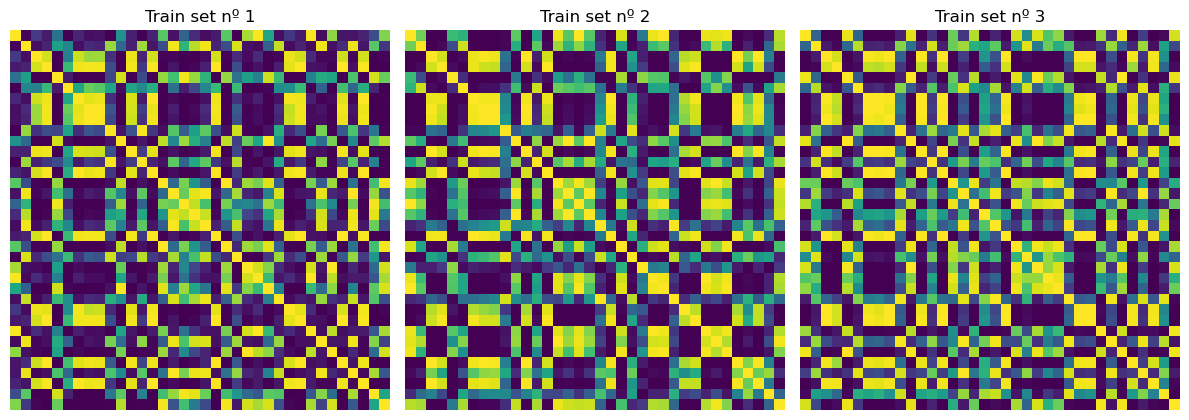

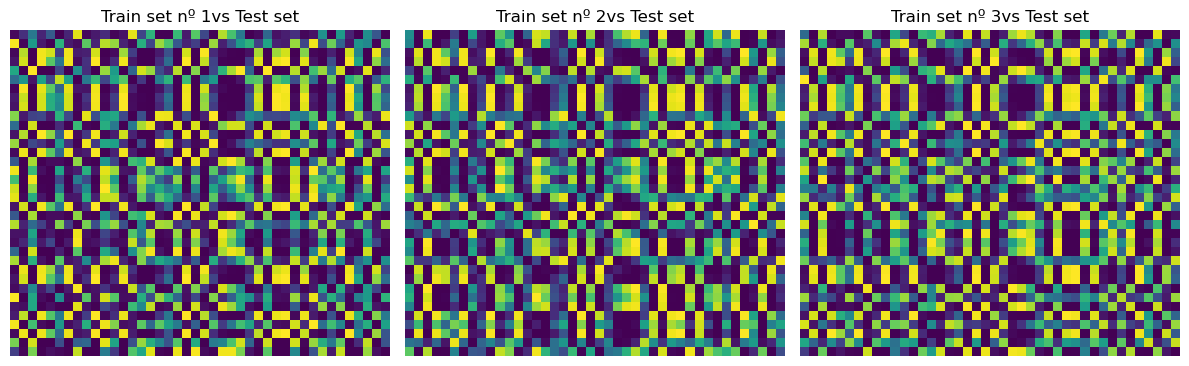

In [34]:
# Plot the kernels for each pair of train sets
Trained_kernels = [QKT_optimized_kernels[i].evaluate(X_subtrain_sets[i]) for i in range(3)]
plot_matrixes(Trained_kernels,['Train set nº '+str(i) for i in range(1,4)])

Train_vs_test_set_kernels = [QKT_optimized_kernels[i].evaluate(X_subtrain_sets[i],X_test) for i in range(3)]
plot_matrixes(Train_vs_test_set_kernels,['Train set nº '+str(i)+'vs Test set' for i in range(1,4)])

## Define the Support Vector Machines with our optimized kernels:

In [35]:
# Define a sklearn Support Vector Classifier, giving as kernel our quantum trained kernels
SVM_list = [SVC(kernel=optimized_kernel.evaluate,probability=True) for optimized_kernel in QKT_optimized_kernels]

# Fit them with the train data
for i in tqdm(range(3)):
    SVM_list[i].fit(X_subtrain_sets[i], y_subtrain_sets[i])

  0%|          | 0/3 [00:00<?, ?it/s]

SVC(kernel=<bound method TrainableFidelityQuantumKernel.evaluate of <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x1498e535fa90>>,
    probability=True)

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]

SVC(kernel=<bound method TrainableFidelityQuantumKernel.evaluate of <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x1498e78d1130>>,
    probability=True)

 67%|██████▋   | 2/3 [00:01<00:00,  1.10it/s]

SVC(kernel=<bound method TrainableFidelityQuantumKernel.evaluate of <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x1498f7b8a820>>,
    probability=True)

100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


In [36]:
# Consistency check that they perform well over the train set:
SVM_train_score = [SVM_list[i].score(X_subtrain_sets[i], y_subtrain_sets[i]) for i in tqdm(range(3))]
print(SVM_train_score)

100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

[1.0, 0.9166666666666666, 1.0]


## Performance of the SVM:

We can obtaing an overall performance score over the test set.

In [37]:
# Score of performance over test set
SVM_test_score = [SVM_list[i].score(X_test, y_test.apply(lambda x: 1 if x==classes[i] else 0)) for i in tqdm(range(3))]
# Note that y_test contains the 3 different labels, we set to 0 the other 2 labels
print(SVM_test_score)

100%|██████████| 3/3 [00:06<00:00,  2.05s/it]

[1.0, 0.9523809523809523, 0.9523809523809523]


95% is quite a good score for the classifier!

To evaluate the performance of the 3 classifiers over the whole test set, we will chose the label of the prediction with highest probability.

We only need the probability of the item in the test set being of the class that distinguishes the classifier that has been trained with the one vs all approach.

In [38]:
# Obtain the predicted probabilities for each class for each example in X_test
SVM_test_predictions = [SVM_list[i].predict_proba(X_test)[:,1] for i in range(3)]

# Combine the predicted probabilities for all classes into a single matrix
SVM_stacked_test_predictions = np.vstack(SVM_test_predictions).T

# Obtain the predicted labels (0,1 or 2) with the highest confidence
SVM_predicted_labels = np.argmax(SVM_test_predictions, axis=0)

In [39]:
SVM_missclassified = []
for index,(predicted_label, true_label) in enumerate(zip(SVM_predicted_labels,y_test)):
    # Match the numeric labels (0,1 or 2) with the names in the 'classes' objects
    if classes[predicted_label] != true_label:
        SVM_missclassified.append(index)
print(f"There are {len(SVM_missclassified)} missclassified items out of {len(y_test)}: {SVM_missclassified}")

There are 2 missclassified items out of 42: [14, 31]


In [40]:
SVM_accuracy = 1-(len(SVM_missclassified)/len(y_test))
print("Statevector SVM joint accuracy",SVM_accuracy)

Statevector SVM joint accuracy 0.9523809523809523


## See the missclassified points:

In [41]:
predictions = pd.concat([pd.DataFrame(SVM_test_predictions).transpose(), pd.DataFrame(y_test.values)], axis=1)
predictions.columns = [item+' vs. all' for item in classes]+['true_value']
predictions.iloc[SVM_missclassified]

,Iris-setosa vs. all,Iris-versicolor vs. all,Iris-virginica vs. all,true_value
14,0.035889,0.540599,0.189889,Iris-virginica
31,0.026974,0.370953,0.513615,Iris-versicolor


In [42]:
# Default colors
colors = [palette[y_test.iloc[i]] for i in range(len(y_test))] 
new_colors = ['yellow','orange','pink','purple','brown']
count = 0
for index in SVM_missclassified:
    colors[index] = new_colors[count]
    count +=1

In [43]:
# De-escale the test set and see the missclassified case
X_test_invscaled = pd.DataFrame(scaler.inverse_transform(X_test), columns=X_test.columns)
X_test_invscaled.iloc[SVM_missclassified]

,sepal_length,sepal_width,petal_length,petal_width
14,6.3,2.8,5.1,1.5
31,6.7,3.0,5.0,1.7


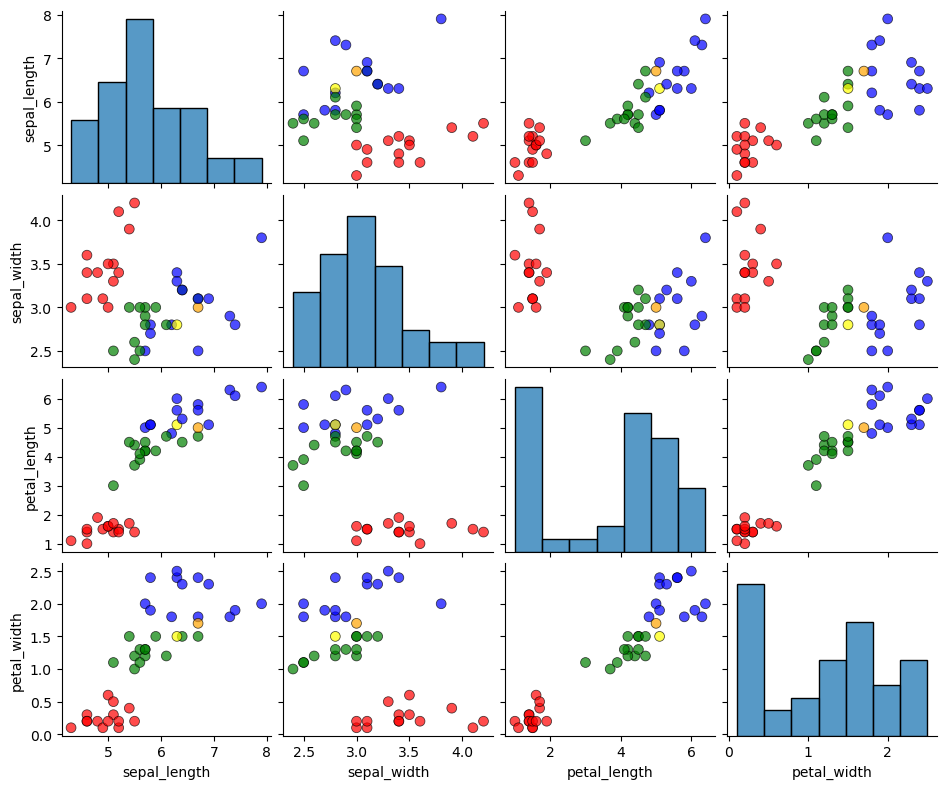

True colors {'Iris-setosa': 'red', 'Iris-versicolor': 'green', 'Iris-virginica': 'blue'}


yellow data point has been classified as 'Iris-versicolor'(green) with a likelihood of 54.06%. True label is 'Iris-virginica' (blue)
orange data point has been classified as 'Iris-virginica'(blue) with a likelihood of 51.36%. True label is 'Iris-versicolor' (green)


In [44]:
sns.pairplot(X_test_invscaled, plot_kws={'s': 50, 'edgecolor': 'k', 'alpha': 0.7, 'color': colors}, height=2, aspect=1.2, diag_kind='hist')
plt.show()
print("True colors",palette)
print("\n")
for index in SVM_missclassified:
    print(f"{colors[index]} data point has been classified as '{classes[np.argmax(predictions.iloc[index].tolist()[:-1])]}'"
          f"({palette[classes[np.argmax(predictions.iloc[index].tolist()[:-1])]]})"
          f" with a likelihood of {np.round(np.max(predictions.iloc[index].tolist()[:-1])*100,2)}%."
          f" True label is '{predictions.iloc[index].tolist()[-1]}' ({palette[predictions.iloc[index].tolist()[-1]]})")

# [Bonus] Aer simulation, without noise, noisy and with error mitigation for the quantum kernels Vs Classical classifier

## Aer Support Vector Classifier

In [45]:
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.primitives import Sampler, BackendSampler

By default the trainable quantum kernel sets fidelity as ``ComputeUncompute(sampler=Sampler())``, 
meaningly the ``Sampler`` primitive is doing an Statevector simulation since it is based on the Statevector construct (i.e. algebraic simulation).
We will run the quantum kernels with the standard aer backend via ``AerSimulator()``, using a noise model and also apply error mitigation to compare with

In [46]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeBackendV2
from qiskit_aer.noise import NoiseModel

In [47]:
aer_backend = AerSimulator()
# noisy_backend = FakeLimaV2()
noisy_backend = FakeBackendV2()
noise_model = NoiseModel.from_backend(noisy_backend)

options_sim = {
    'simulator': {"seed_simulator": seed},
    'resilience_level': 0
}

options_noise = {
    'simulator': {
        "noise_model": noise_model,
        "seed_simulator": seed
    },
    'resilience_level': 0
}

options_error_mitigation = {
    'simulator': {
        "noise_model": noise_model,
        "seed_simulator": seed
    },
    'resilience_level': 1
}

options_list = [options_sim,options_noise,options_error_mitigation]

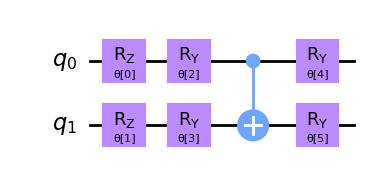

[[{ParameterVectorElement(θ[4]): 1.645318057313193,
   ParameterVectorElement(θ[5]): 0.5334504944367562},
  {ParameterVectorElement(θ[4]): 2.4914495473586173,
   ParameterVectorElement(θ[5]): -2.19404628858427},
  {ParameterVectorElement(θ[4]): 0.02601643154490052,
   ParameterVectorElement(θ[5]): 2.207827723631043}],
 [{ParameterVectorElement(θ[4]): -1.9935451981655543,
   ParameterVectorElement(θ[5]): 0.7123700470400931},
  {ParameterVectorElement(θ[4]): -1.3515938403680503,
   ParameterVectorElement(θ[5]): 2.2594987667797053},
  {ParameterVectorElement(θ[4]): 0.24318568440492028,
   ParameterVectorElement(θ[5]): -0.38187394341751446}],
 [{ParameterVectorElement(θ[4]): -1.0989475831476812,
   ParameterVectorElement(θ[5]): 2.786064018764584},
  {ParameterVectorElement(θ[4]): 1.5831105989044527,
   ParameterVectorElement(θ[5]): -0.41968701095072136},
  {ParameterVectorElement(θ[4]): 2.831211192767296,
   ParameterVectorElement(θ[5]): -0.03491251124444261}]]

In [48]:
# We will use the same circuit
TL.draw()

# We fix new random training parameters for the 9 circuits (one per sub train set and per method)
aer_initial_training_parameters_list = [[{item:rand(-np.pi,np.pi,1)[0] for item in TL.parameters[4:6]} for i in range(3)] for k in range(3)]
aer_initial_training_parameters_list

### Train the aer Quantum Kernels:

In [49]:
# Define a Trainable Fidelity Quantum Kernel per simulation method
aer_TFQK_list = [TrainableFidelityQuantumKernel(
    feature_map=TL,
    fidelity=ComputeUncompute(sampler=BackendSampler(backend=AerSimulator()),options=config),
    training_parameters=TL.parameters[4:6]
) for config in options_list]

# Define 3 Quantum Kernel Trainers per method (for each training set)
aer_QKT_list = [[QuantumKernelTrainer(
    quantum_kernel=TFQK,
    loss="svc_loss",
    optimizer=custom_optimizer, # alternatively use optimzier=SLSQP(maxiter=1000),
    initial_point=list(aer_initial_training_parameters_list[k][i].values())
) for i,TFQK in enumerate(aer_TFQK_list)] for k in range(3)]

We will train the 3 types of Quantum Kernels (statevector aer simulation, noisy aer simulation and error mitigation aer simulation) over the 3 sub-train datasets.

IMPORTANT: The training process can last for some time since we are using a noisy model. Therefore, it is recommended to skip to the cell where the ``aer_qkernels`` list is loaded via ``load_from_pickle`` function.

In [50]:
%%time
aer_QKT_fit_results = [
    [QKT.fit(X_subtrain_sets[k], y_subtrain_sets[k]) for QKT in tqdm(sub_train_set,leave=False)]
    for k,sub_train_set in tqdm(enumerate(aer_QKT_list))
]

0it [00:00, ?it/s]
100%|██████████| 3/3 [01:16<00:00, 25.12s/it]
1it [01:16, 76.94s/it]                       
100%|██████████| 3/3 [01:16<00:00, 25.10s/it]
2it [02:33, 76.89s/it]                       
100%|██████████| 3/3 [02:02<00:00, 39.62s/it]
3it [04:36, 92.05s/it]                       

CPU times: user 3min 57s, sys: 30.1 s, total: 4min 27s
Wall time: 4min 36s


In [49]:
%%time
aer_QKT_fit_results = [
    [QKT.fit(X_subtrain_sets[k], y_subtrain_sets[k]) for QKT in tqdm(sub_train_set,leave=False)]
    for k,sub_train_set in tqdm(enumerate(aer_QKT_list))
]

0it [00:00, ?it/s]
100%|██████████| 3/3 [23:37<00:00, 457.37s/it]
1it [23:37, 1417.90s/it]                      
100%|██████████| 3/3 [24:30<00:00, 509.52s/it]
2it [48:07, 1448.58s/it]                      
100%|██████████| 3/3 [22:30<00:00, 462.35s/it]
3it [1:10:38, 1412.67s/it]                    

CPU times: user 1h 21s, sys: 7min 54s, total: 1h 8min 16s
Wall time: 1h 10min 38s


In [51]:
# Retrieve the optimized quantum kernels
aer_qkernels = [[qkernel.quantum_kernel for qkernel in sub_train_set] for sub_train_set in aer_QKT_fit_results]

In [52]:
add_to_pickle('aer_qkernels.dat',aer_qkernels)
add_to_pickle('aer_QKT_fit_results.dat',aer_QKT_fit_results)

In [53]:
# # YOU MAY RUN THIS CELL INSTEAD OF THE 3 PREVIOUS ONES:
# aer_qkernels = load_from_pickle('aer_qkernels.dat')
# aer_QKT_fit_results = load_from_pickle('aer_QKT_fit_results.dat')

Recall that the structure of these lists is ``Sub_train datasets > Simulation_method``

In [54]:
aer_opt_params = [[aer_qkernels[k][i].parameter_values for i in range(3)] for k in range(3)]
print("Optimal training paramters \n",aer_opt_params)
# Note that initial points are indeed not optimal points, so an optimization has taken place!
# [[np.allclose(aer_opt_params[k][i],list(aer_initial_training_parameters_list[k][i].values())) for i in range(3)] for k in range(3)]

Optimal training paramters 
 [[array([1.64531806, 0.53345049]), array([ 2.49208446, -2.18883569]), array([0.02601643, 2.20782772])], [array([-1.9935452 ,  0.71237005]), array([-1.35334188,  2.25422427]), array([ 0.24318568, -0.38187394])], [array([-1.09894758,  2.78606402]), array([ 1.58002309, -0.41273476]), array([ 2.83121119, -0.03491251])]]


In [55]:
aer_opt_values = [[aer_QKT_fit_results[k][i].optimal_value for i in range(3)] for k in range(3)]
print("svc_loss optimized value",aer_opt_values)

svc_loss optimized value [[2.8379498149120845, 2.8422122148777422, 2.840455012032719], [9.406021329848349, 9.333219314514182, 9.354330508728095], [4.905062945496049, 4.826847719757955, 4.863610826855004]]


### Display aer kernel matrixes:

IMPORTANT: Building the kernel matrixes may take some minutes, consider loading them in the cell that reads ``load_from_pickle``

In [56]:
%%time
# Obtin the corresponding kernel matrixes:
aer_trained_kernels = [[qkernel.evaluate(X_subtrain_sets[k]) for qkernel in sub_train_set] for k,sub_train_set in enumerate(aer_qkernels)]
aer_trained_vs_test_kernels = [[qkernel.evaluate(X_subtrain_sets[k],X_test) for qkernel in sub_train_set] for k,sub_train_set in enumerate(aer_qkernels)]

CPU times: user 2min 4s, sys: 7.67 s, total: 2min 12s
Wall time: 2min 14s


In [57]:
add_to_pickle('aer_trained_kernels.dat',aer_trained_kernels)
add_to_pickle('aer_trained_vs_test_kernels.dat',aer_trained_vs_test_kernels)

In [53]:
# aer_trained_kernels = load_from_pickle('aer_trained_kernels.dat')
# aer_trained_vs_test_kernels = load_from_pickle('aer_trained_vs_test_kernels.dat')

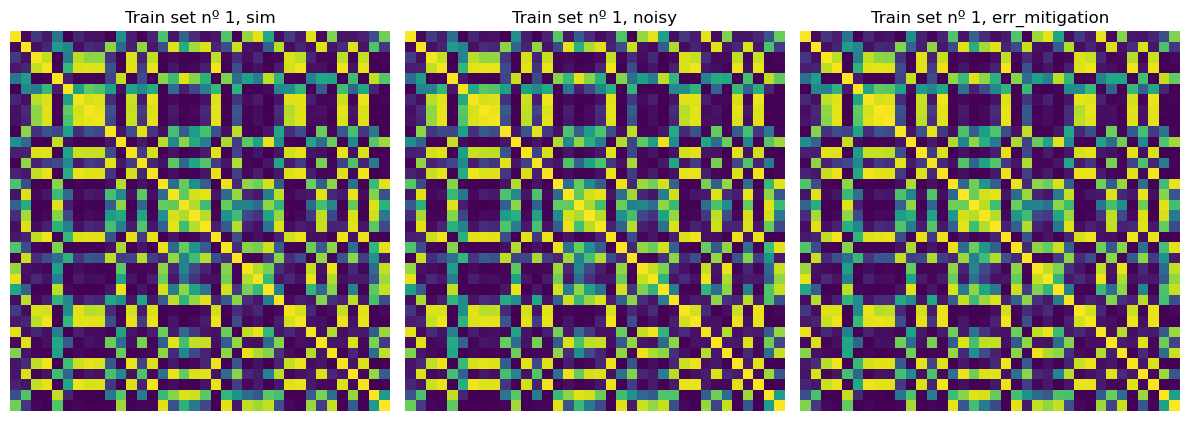

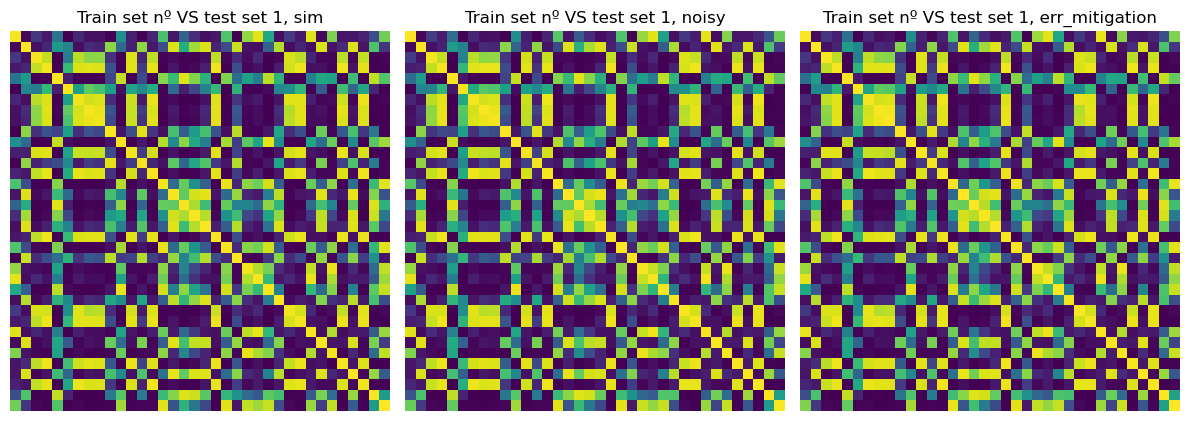

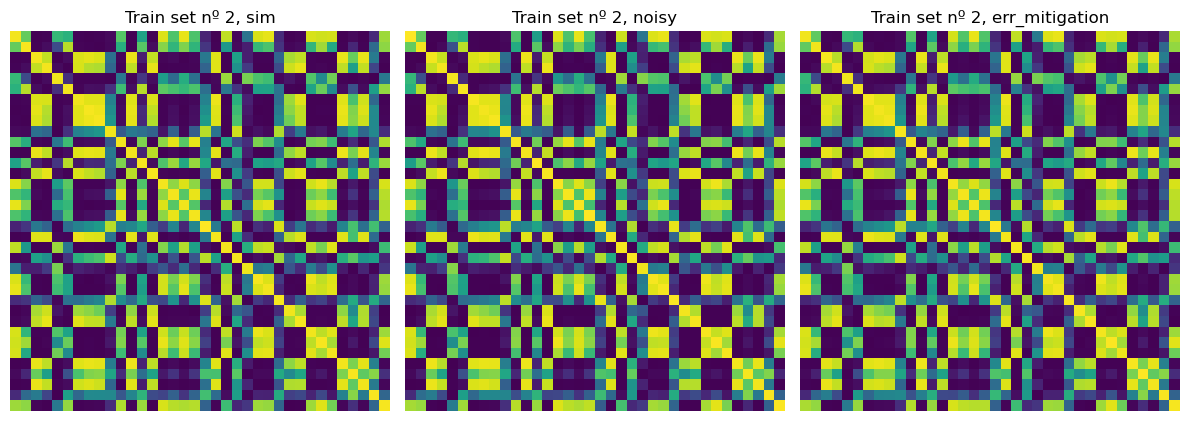

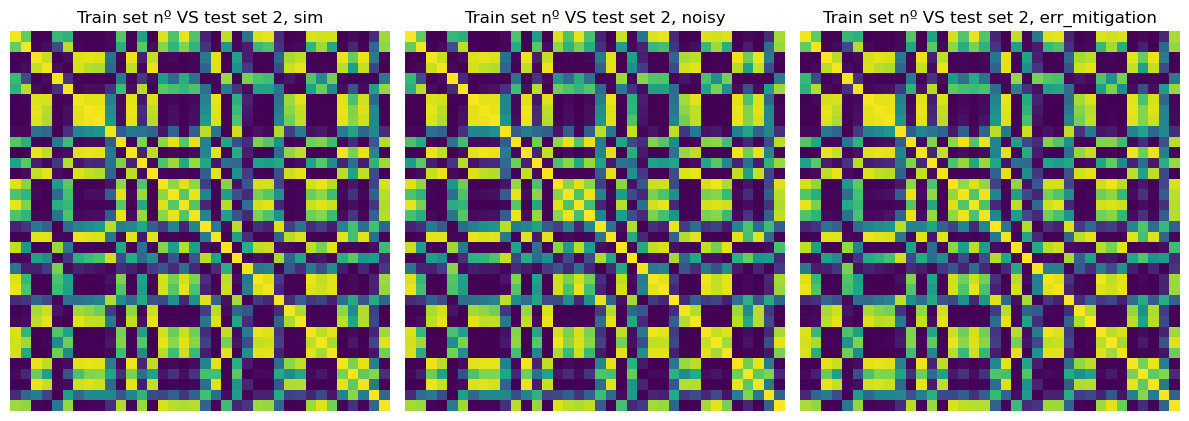

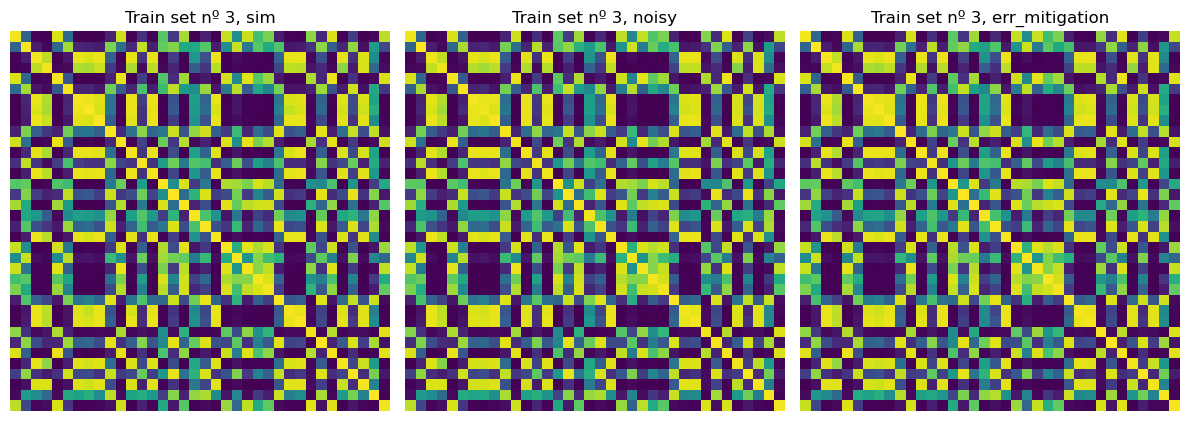

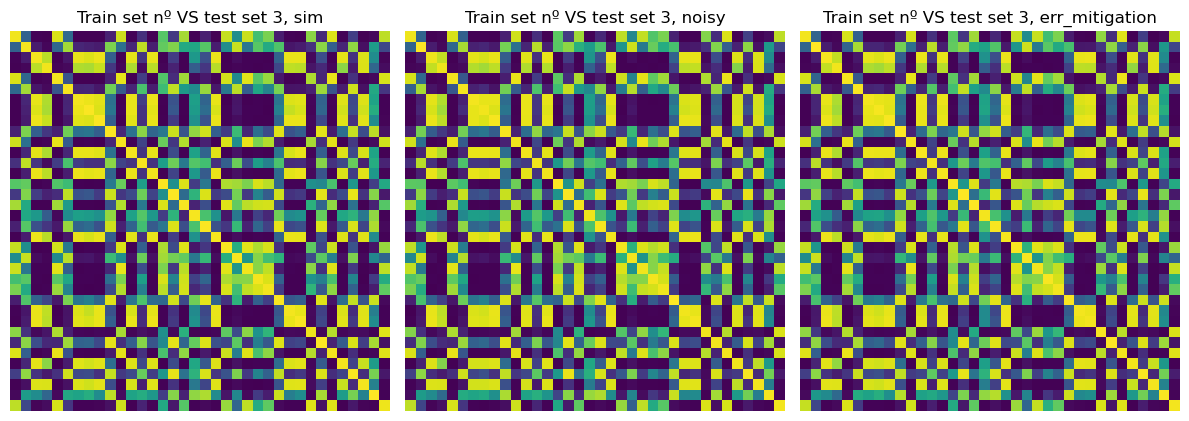

In [58]:
# Plot the kernels for each pair of train sets
labels = ['sim','noisy','err_mitigation']

for k in range(3):
    plot_matrixes(aer_trained_kernels[k],['Train set nº '+str(k+1)+', '+label for label in labels])
    plot_matrixes(aer_trained_kernels[k],['Train set nº VS test set '+str(k+1)+', '+label for label in labels])
    print("\n")

### Build the aer Support Vector Classifiers with the trained data

In [59]:
aer_svm_list = [[SVC(kernel=qkernel.evaluate, probability=True) for qkernel in sub_train_set] for sub_train_set in aer_qkernels]

Fit the Support Vector Classifiers to the correspondent train data

In [60]:
%%time
for k,sub_train_set in enumerate(aer_svm_list):
    for svm in sub_train_set:
        svm.fit(X_subtrain_sets[k], y_subtrain_sets[k])

CPU times: user 26.6 s, sys: 3.83 s, total: 30.4 s
Wall time: 31.5 s


Print the scores of the classifiers

In [61]:
# # Train scores (in case you want to see them)
# aer_train_scores = [
#     [qkernel.score(X_subtrain_sets[k], y_subtrain_sets[k]) for qkernel in sub_train_set]
#     for k,sub_train_set in enumerate(aer_svm_list)
# ]
# print(aer_train_scores)

### Evaluate the aer Support Vector Classifiers performance over the test set.

We can obtaing an overall performance score over the test set for all the trained sets

In [62]:
# Obtain the test scores
aer_test_scores = [
    [qkernel.score(X_test, y_test.apply(lambda x: 1 if x==classes[k] else 0)) for qkernel in tqdm(sub_train_set)]
    for k,sub_train_set in tqdm(enumerate(aer_svm_list))
]
print(aer_test_scores)

0it [00:00, ?it/s]
100%|██████████| 3/3 [00:34<00:00, 11.55s/it]
1it [00:34, 34.65s/it]
100%|██████████| 3/3 [00:34<00:00, 11.56s/it]
2it [01:09, 34.66s/it]
100%|██████████| 3/3 [00:34<00:00, 11.53s/it]
3it [01:43, 34.63s/it]

[[1.0, 1.0, 1.0], [0.9523809523809523, 0.9523809523809523, 0.9523809523809523], [0.9523809523809523, 0.9523809523809523, 0.9523809523809523]]


- For the first training set, all clasifier perform perfectly.
- For the second and third training set, we reach the almost the same accuracy for all cases (except for noisy SVM for the second train dataset).
- In general all accuracies are or 100% or 95% (except for the case mentioned, a 92%).
- The performance is the almost the same to the one of the Statevector simulations. 

Above 95%, overall, is quite a good score for the classifier!

To evaluate the performance of the 3 classifiers over the whole test set, per each method, we will chose the label of the prediction with highest probability.

We only need the probability of the item in the test set being of the class that distinguishes the classifier that has been trained with the one vs all approach.

In [63]:
# Obtain the predicted probabilities for each class for each example in X_test
aer_test_predictions = [[aer_svm_list[k][i].predict_proba(X_test)[:,1] for k in range(3)] for i in range(3)]
# Note that we now group first per simulation method and them per train group!

# Combine the predicted probabilities for all train sets into a single matrix for each simulation method
aer_stacked_test_predictions = [np.vstack(simulation_method).T for simulation_method in aer_test_predictions]

# Obtain the predicted labels (0,1 or 2) with the highest confidence
aer_predicted_labels = [np.argmax(simulation_method, axis=0) for simulation_method in aer_test_predictions] 

In [64]:
simulation_method_names = ['noiselees','noisy','error mitigation']
aer_missclassified = [[],[],[]]
for i,simulation_method in enumerate(aer_predicted_labels):
    for index,(predicted_label, true_label) in enumerate(zip(simulation_method,y_test)):
        # Match the numeric labels (0,1 or 2) with the names in the 'classes' objects
        if classes[predicted_label] != true_label:
            aer_missclassified[i].append(index)
    print(f"There are {len(aer_missclassified[i])} missclassified items out of {len(y_test)}"
          f" for the {simulation_method_names[i]} simulation: {aer_missclassified[i]}")

There are 2 missclassified items out of 42 for the noiselees simulation: [14, 31]
There are 2 missclassified items out of 42 for the noisy simulation: [14, 31]
There are 2 missclassified items out of 42 for the error mitigation simulation: [14, 31]


In [65]:
aer_accuracy = [1-(len(aer_missclassified[i])/len(y_test)) for i in range(3)]
print("Statevector SVM joint accuracy:")
for i in range(3):
    print(f"{simulation_method_names[i]} simulation: {aer_accuracy[i]}")

Statevector SVM joint accuracy:
noiselees simulation: 0.9523809523809523
noisy simulation: 0.9523809523809523
error mitigation simulation: 0.9523809523809523


- All aer simulation types have the same accuracy over the test set, which is also the same as the Statevector past approach.
- The missclassified items are the same as before.

In [66]:
prediction_datasets = []
for simulation_index,simulation_method in enumerate(aer_missclassified):
    # for missclassified_index in simulation_method:
    prediction_datasets.append(
        pd.DataFrame(
            [[missclassified_index] + list(aer_stacked_test_predictions[simulation_index][missclassified_index]) + [y_test.iloc[missclassified_index]] 
             for missclassified_index in simulation_method
            ], columns = ['index']+classes+['True label']
        ).set_index('index').style.set_caption(simulation_method_names[simulation_index])
    )
    
for dataset in prediction_datasets:
    dataset
    print("\n")

,Iris-setosa,Iris-versicolor,Iris-virginica,True label
index,,,,
14,0.037983,0.518226,0.192383,Iris-virginica
31,0.027618,0.364706,0.494728,Iris-versicolor


,Iris-setosa,Iris-versicolor,Iris-virginica,True label
index,,,,
14,0.037463,0.541341,0.221341,Iris-virginica
31,0.029049,0.364335,0.535462,Iris-versicolor


,Iris-setosa,Iris-versicolor,Iris-virginica,True label
index,,,,
14,0.036878,0.446373,0.173582,Iris-virginica
31,0.025924,0.309362,0.516713,Iris-versicolor


We see that the labels of these items are predicted with nearly 50% confidence, similar to the previous Statevector case.

## Classical Support Vector Classifiers:

We select a a small pool of classical kernel types that are avaliable to benchmark and compare with the previous Support Vector Machines.

In [67]:
classical_kernel_types = {'linear', 'poly', 'rbf', 'sigmoid'}
classical_svm_list = [[SVC(kernel = kernel_type,probability=True) for kernel_type in classical_kernel_types] for k in range(3)]

Fit the classical SVC with the data

In [68]:
%%time
for k,sub_train_set in tqdm(enumerate(classical_svm_list)):
    for svm in tqdm(sub_train_set):
        svm.fit(X_subtrain_sets[k], y_subtrain_sets[k],)

0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 576.24it/s]

100%|██████████| 4/4 [00:00<00:00, 502.06it/s]

100%|██████████| 4/4 [00:00<00:00, 632.74it/s]
3it [00:00, 115.07it/s]

CPU times: user 27 ms, sys: 2.1 ms, total: 29.1 ms
Wall time: 27.1 ms


In [69]:
# # Train scores (in case you want to see them)
# classical_train_scores = [
#     [qkernel.score(X_subtrain_sets[k], y_subtrain_sets[k]) for qkernel in sub_train_set]
#     for k,sub_train_set in enumerate(classical_svm_list)
# ]
# print(classical_train_scores)

Overall test scores of the classical classifiers:

In [70]:
# Obtain the test scores
classical_test_scores = [
    [ckernel.score(X_test, y_test.apply(lambda x: 1 if x==classes[k] else 0)) for ckernel in sub_train_set]
    for k,sub_train_set in enumerate(classical_svm_list)
]
print(classical_test_scores)

[[0.9761904761904762, 1.0, 1.0, 1.0], [0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.9523809523809523], [0.9285714285714286, 0.9761904761904762, 0.9047619047619048, 0.9285714285714286]]


- We see that using different kernels, we can get up to 100%, 95% and 97% accuracy over the different train sets, respectively.
- In comparison to the statevector simulation and the aer simulations, there is a better performance over the last train set.

To compare with the previous cases, we will select the best classifier for each training set.

In [71]:
best_classical_svm = [sub_train_set[np.argmax(classical_test_scores[index])] for index,sub_train_set in enumerate(classical_svm_list)]
best_classical_svm

[SVC(kernel='linear', probability=True),
 SVC(probability=True),
 SVC(kernel='linear', probability=True)]

In [72]:
# Obtain the predicted probabilities for each class for each example in X_test
classical_test_predictions = [best_classical_svm[k].predict_proba(X_test)[:,1] for k in range(3)]

# Combine the predicted probabilities for all train sets into a single matrix for each simulation method
classical_stacked_test_predictions = np.vstack(classical_test_predictions).T

# Obtain the predicted labels (0,1 or 2) with the highest confidence
classical_predicted_labels = np.argmax(classical_stacked_test_predictions, axis=1)

In [73]:
classical_missclassified = []
for index,(predicted_label, true_label) in enumerate(zip(classical_predicted_labels,y_test)):
    # Match the numeric labels (0,1 or 2) with the names in the 'classes' objects
    if classes[predicted_label] != true_label:
        classical_missclassified.append(index)
print(f"{len(classical_missclassified)} missclassified item(s) out of {len(y_test)}: {classical_missclassified}")

1 missclassified item(s) out of 42: [14]


In [74]:
classical_accuracy = 1-(len(classical_missclassified)/len(y_test))
print("Best classical classifiers joint accuracy",classical_accuracy)

Best classical classifiers joint accuracy 0.9761904761904762


# Conclusion:

In [76]:
import qiskit.tools.jupyter
%qiskit_version_table